In [6]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from skbold.preproc import ConfoundRegressor
import matplotlib.pyplot as plt
%matplotlib inline

### Minimally reproducible example for below-chance accuracy
This occurs when the correlations between y and X are _forced_ to be 0.

# 1. Single confound, confound == y
## 1.1 Regress out confound in advance 
Effectively, this sets the correlation between the confound and X to 0.
Therefore, what I simulate below is NOT doing the regression in advance, but inspecting the effect of using a K-fold cross-validation procedure on data in which the correlation between X and y is set to be a certain value. This allows for some examination of the importance of _allowing_ correlations between X and y to exist, and it shows what the 'minimally allowable' correlation between X and y is.
For all graphs in Section 1, regressing out in advance would be the equivalent of setting the correlation between X and y to 0.

In [2]:
n_obs = 100  # Number of observations
n_ind = 25   # Number of independent variables (X)
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# In the code that follows, we generated multiple variables X, and ensure that the correlation 
# between X and the confound is below a certain value. To mimick the effect of regressing out 
# a confound before doing any other analyses/processing, you can set the maximally allowed 
# correlation to 0.00001. Here, we create an array to visualize the effect of multiple possible scenarios.
max_corr_x_conf = [.0001, .0003, .001, .003, .01, 0.03, .1, 0.15, 0.2, 0.25, .3, 1]

# For every value of 'max_corr_x_conf', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 10

# Pre-allocate DataFrame for results
accuracies_1_1 = pd.DataFrame(columns=max_corr_x_conf, index=range(n_datasets))

# First, loop over the array of maximum correlations
for i, max_correlation in enumerate(max_corr_x_conf):
    print('Maximum correlation between x and the confound: %.4f' % max_correlation)
    
    # Loop over datasets
    for dataset_num in range(n_datasets):

        # Generate y first
        y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))

        # Generate empty array X of size (n_obs, n_ind)
        X = np.ndarray((n_obs, n_ind))
        
        # Set default noise sd for generating X
        noise_sd = 1
        for i in range(n_ind):

            # Generate random vector, enforcing a (Pearson's) correlation between y and X lower than max_correlation.
            # Ideally, you would use something like np.random.bivariate_normal for this; but y is a binary variable 
            # in our case. Maybe this method can be used:
            # https://www.r-bloggers.com/easily-generate-correlated-variables-from-any-distribution-without-copulas/
            attempt = 0
            while True:
                attempt += 1
                random_vec = np.random.normal(0, noise_sd, n_obs)

                if np.abs(np.corrcoef(x=random_vec, y=y)[0,1]) < max_correlation:
                    X[:,i] = random_vec
                    break

                if attempt > 10000:
                    # after 10.000 attempts at generting an X with the specified correlation with y, lower the amount of noise
                    noise_sd = noise_sd-.005
                    print('Tried 10000 generations, decreasing amount of noise...')

        # 10-fold stratified CV
        cv = StratifiedKFold(n_splits=n_splits)
        
        # Pipeline
        pipe = Pipeline([('scale', StandardScaler()), 
                         ('svc', SVC(kernel='linear'))])
        
        # Initialize list for scores
        scores = []
        for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
            X_train = X[train_idx,:]
            X_test = X[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]

            pipe.fit(X_train, y_train)  # Fit pipeline
            fold_scores = pipe.score(X_test, y_test)  # Score
            scores.append(fold_scores)
        
        # Calculate mean accuracy for this dataset, and include in DataFrame
        scores = np.array(scores)
        accuracies_1_1.loc[dataset_num, max_correlation] = scores.mean(axis=0)
        
        if not silent:
            print('###########\nDone. Mean accuracy over folds: %.3f\n##########\n' %scores.mean(axis=0))

Maximum correlation between x and the confound: 0.0001
Maximum correlation between x and the confound: 0.0003
Maximum correlation between x and the confound: 0.0010
Maximum correlation between x and the confound: 0.0030
Maximum correlation between x and the confound: 0.0100
Maximum correlation between x and the confound: 0.0300
Maximum correlation between x and the confound: 0.1000
Maximum correlation between x and the confound: 0.1500
Maximum correlation between x and the confound: 0.2000
Maximum correlation between x and the confound: 0.2500
Maximum correlation between x and the confound: 0.3000
Maximum correlation between x and the confound: 1.0000


The mean scores for each `max_corr_x_conf`:

In [15]:
accuracies_1_1.mean(axis=0)

0.0001    0.118
0.0003    0.120
0.0010    0.125
0.0030    0.117
0.0100    0.135
0.0300    0.152
0.1000    0.312
0.1500    0.439
0.2000    0.458
0.2500    0.501
0.3000    0.503
1.0000    0.517
dtype: float64

Visualizing is always a good idea

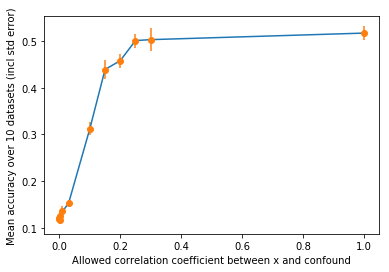

In [18]:
# First, compute error bars
errors = np.std(accuracies_1_1, axis=0)
errors = errors / np.sqrt(accuracies_1_1.shape[0])

# Figure, axis
f, ax = plt.subplots(1,1)
ax = plt.plot(accuracies_1_1.columns, accuracies_1_1.mean(axis=0))  # Add means
plt.errorbar(x=accuracies_1_1.columns, y=accuracies_1_1.mean(axis=0), yerr=errors, fmt='o')  # add error bars
plt.ylabel('Mean accuracy over 10 datasets (incl std error)')
plt.xlabel('Allowed correlation coefficient between x and confound')

Clearly, starting out with a dataset with a correlation of 0 between x and confound is NOT a good idea!

## 1.2. Within-fold regression: remove confound within the folds

In [10]:
n_obs = 100  # Number of observations
n_ind = 25   # Number of independent variables (X)
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# In the code that follows, we generated multiple variables X, and ensure that the correlation 
# between X and the confound is below a certain value. To mimick the effect of regressing out 
# a confound before doing any other analyses/processing, you can set the maximally allowed 
# correlation to 0.00001. Here, we create an array to visualize the effect of multiple possible scenarios.
max_corr_x_conf = [.0001, .0003, .001, .003, .01, 0.03, .1, 0.15, 0.2, 0.25, .3, 1]

# For every value of 'max_corr_x_conf', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 10

# Pre-allocate DataFrame for results
accuracies_1_2 = pd.DataFrame(columns=max_corr_x_conf, index=range(n_datasets))

# First, loop over the array of maximum correlations
for i, max_correlation in enumerate(max_corr_x_conf):
    print('Maximum correlation between x and the confound: %.4f' % max_correlation)
    
    # Loop over datasets
    for dataset_num in range(n_datasets):

        # Generate y first
        y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))

        # Generate empty array X of size (n_obs, n_ind)
        X = np.ndarray((n_obs, n_ind))
        
        # Set default noise sd for generating X
        noise_sd = 1
        for i in range(n_ind):

            # Generate random vector, enforcing a (Pearson's) correlation between y and X lower than max_correlation.
            # Ideally, you would use something like np.random.bivariate_normal for this; but y is a binary variable 
            # in our case. Maybe this method can be used:
            # https://www.r-bloggers.com/easily-generate-correlated-variables-from-any-distribution-without-copulas/
            attempt = 0
            while True:
                attempt += 1
                random_vec = np.random.normal(0, noise_sd, n_obs)

                if np.abs(np.corrcoef(x=random_vec, y=y)[0,1]) < max_correlation:
                    X[:,i] = random_vec
                    break

                if attempt > 10000:
                    # after 10.000 attempts at generting an X with the specified correlation with y, lower the amount of noise
                    noise_sd = noise_sd-.005
                    print('Tried 10000 generations, decreasing amount of noise...')

        # 10-fold stratified CV
        cv = StratifiedKFold(n_splits=n_splits)
                
        # Initialize list for scores
        scores = []
        for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
            X_train = X[train_idx,:]
            X_test = X[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]
            
            # Pipeline
            pipe = Pipeline([('confreg', ConfoundRegressor(confound=y, fit_idx=train_idx)),
                             ('scale', StandardScaler()), 
                             ('svc', SVC(kernel='linear'))])

            pipe.fit(X_train, y_train)  # Fit pipeline
            fold_scores = pipe.score(X_test, y_test)  # Score
            scores.append(fold_scores)
        
        # Calculate mean accuracy for this dataset, and include in DataFrame
        scores = np.array(scores)
        accuracies_1_2.loc[dataset_num, max_correlation] = scores.mean(axis=0)
        
        if not silent:
            print('###########\nDone. Mean accuracy over folds: %.3f\n##########\n' % scores.mean(axis=0))

Maximum correlation between x and the confound: 0.0001
Maximum correlation between x and the confound: 0.0003
Maximum correlation between x and the confound: 0.0010
Maximum correlation between x and the confound: 0.0030
Maximum correlation between x and the confound: 0.0100
Maximum correlation between x and the confound: 0.0300
Maximum correlation between x and the confound: 0.1000
Maximum correlation between x and the confound: 0.1500
Maximum correlation between x and the confound: 0.2000
Maximum correlation between x and the confound: 0.2500
Maximum correlation between x and the confound: 0.3000
Maximum correlation between x and the confound: 1.0000


Again, let's inspect the mean accuracies (i.e., mean across data sets)

In [19]:
accuracies_1_2.mean(axis=0)

0.0001    0.5
0.0003    0.5
0.0010    0.5
0.0030    0.5
0.0100    0.5
0.0300    0.5
0.1000    0.5
0.1500    0.5
0.2000    0.5
0.2500    0.5
0.3000    0.5
1.0000    0.5
dtype: float64

Visualize...

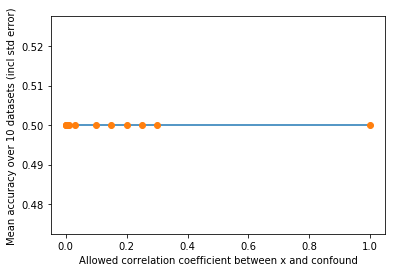

In [21]:
# First, computer error bars
errors = np.std(accuracies_1_2, axis=0)
errors = errors / np.sqrt(accuracies_1_2.shape[0])

# Figure, axis
f, ax = plt.subplots(1,1)
ax = plt.plot(accuracies_1_2.columns, accuracies_1_2.mean(axis=0))  # Add means
plt.errorbar(x=accuracies_1_2.columns, y=accuracies_1_2.mean(axis=0), yerr=errors, fmt='o')  # add error bars
plt.ylabel('Mean accuracy over 10 datasets (incl std error)')
plt.xlabel('Allowed correlation coefficient between x and confound')

This works perfectly: all accuracies are exactly 50%.
#### NB: There is no variance, therefore, no error bars
There is no variance in prediction accuracy - it is 50% in every fold for every data set. The underlying reason is that, within the train set, there is an enforced correlation of 0 between x and y. The classifier cannot learn anything, and therefore, all parameters are 0 (except for some rounding error).
The consequence of setting all parameters to 0 is that a classifier always predicts either 1 or 0 (depending on the rounding error). As we are using stratified K-fold crossvalidation, this implies that accuracy is always 50%.

## 1.3. Remove confound within folds, separately for train and test set
A second option is to remove the confound within the folds but train a seperate Regression model for the train and test set.

In [20]:
n_obs = 100  # Number of observations
n_ind = 25   # Number of independent variables (X)
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# In the code that follows, we generated multiple variables X, and ensure that the correlation 
# between X and the confound is below a certain value. To mimick the effect of regressing out 
# a confound before doing any other analyses/processing, you can set the maximally allowed 
# correlation to 0.00001. Here, we create an array to visualize the effect of multiple possible scenarios.
max_corr_x_conf = [.0001, .0003, .001, .003, .01, 0.03, .1, 0.15, 0.2, 0.25, .3, 1]

# For every value of 'max_corr_x_conf', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 10

# Pre-allocate DataFrame for results
accuracies_1_3 = pd.DataFrame(columns=max_corr_x_conf, index=range(n_datasets))

# First, loop over the array of maximum correlations
for i, max_correlation in enumerate(max_corr_x_conf):
    print('Maximum correlation between x and the confound: %.4f' % max_correlation)
    
    # Loop over datasets
    for dataset_num in range(n_datasets):

        # Generate y first
        y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))

        # Generate empty array X of size (n_obs, n_ind)
        X = np.ndarray((n_obs, n_ind))
        
        # Set default noise sd for generating X
        noise_sd = 1
        for i in range(n_ind):

            # Generate random vector, enforcing a (Pearson's) correlation between y and X lower than max_correlation.
            # Ideally, you would use something like np.random.bivariate_normal for this; but y is a binary variable 
            # in our case. Maybe this method can be used:
            # https://www.r-bloggers.com/easily-generate-correlated-variables-from-any-distribution-without-copulas/
            attempt = 0
            while True:
                attempt += 1
                random_vec = np.random.normal(0, noise_sd, n_obs)

                if np.abs(np.corrcoef(x=random_vec, y=y)[0,1]) < max_correlation:
                    X[:,i] = random_vec
                    break

                if attempt > 10000:
                    # after 10.000 attempts at generting an X with the specified correlation with y, lower the amount of noise
                    noise_sd = noise_sd-.005
                    print('Tried 10000 generations, decreasing amount of noise...')

        # 10-fold stratified CV
        cv = StratifiedKFold(n_splits=n_splits)
                
        # Initialize list for scores
        scores = []
        for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
            X_train = X[train_idx,:]
            X_test = X[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]
            
            # Set train idx in pipeline
            # Pipeline
            pipe = Pipeline([('confreg', ConfoundRegressor(confound=y, fit_idx=train_idx, cross_validate=False)),
                             ('scale', StandardScaler()), 
                             ('svc', SVC(kernel='linear'))])

#            pipe.set_params(confreg__fit_idx=train_idx)
            pipe.fit(X_train, y_train)  # Fit pipeline
            fold_scores = pipe.score(X_test, y_test)  # Score
            scores.append(fold_scores)
        
        # Calculate mean accuracy for this dataset, and include in DataFrame
        scores = np.array(scores)
        accuracies_1_3.loc[dataset_num, max_correlation] = scores.mean(axis=0)
        
        if not silent:
            print('###########\nDone. Mean accuracy over folds: %.3f\n##########\n' % scores.mean(axis=0))

Maximum correlation between x and the confound: 0.0001
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test


Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
F

Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
F

Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
F

Inspect mean accuracies

In [23]:
accuracies_1_3.mean(axis=0)

0.0001    0.5
0.0003    0.5
0.0010    0.5
0.0030    0.5
0.0100    0.5
0.0300    0.5
0.1000    0.5
0.1500    0.5
0.2000    0.5
0.2500    0.5
0.3000    0.5
1.0000    0.5
dtype: float64

Visualize

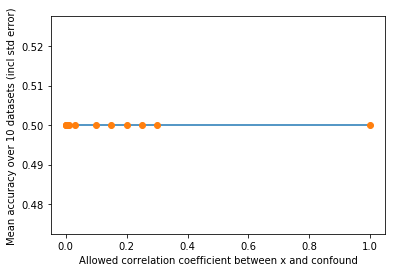

In [22]:
# First, computer error bars
errors = np.std(accuracies_1_3, axis=0)
errors = errors / np.sqrt(accuracies_1_3.shape[0])

# Figure, axis
f, ax = plt.subplots(1,1)
ax = plt.plot(accuracies_1_3.columns, accuracies_1_3.mean(axis=0))  # Add means
plt.errorbar(x=accuracies_1_3.columns, y=accuracies_1_3.mean(axis=0), yerr=errors, fmt='o')  # add error bars
plt.ylabel('Mean accuracy over 10 datasets (incl std error)')
plt.xlabel('Allowed correlation coefficient between x and confound')

The results are identical to the results obtained before in Section 1.2.

# 2. Single confound, cor(confound, y) < 1
What happens if there is a single confound, but the correlation between the confound and y is NOT 1 but lower? Again, we have three options: regress in advance (= set correlation between the confound and X to 0 in advance), or regress within the folds

## 2.1 Regress in advance

In [43]:
n_obs = 100  # Number of observations
n_ind = 25   # Number of independent variables (X)
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# Here, we define several values for the point-biserial correlation between the confound and y.
# This value cannot be set too high; it is impossible to have very high correlations between a normally distributed and
# a binary variable.
corr_y_conf = [.7, .6, .5, .4, .3, .2, .1]

# For every 'corr_y_conf', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 30

# Pre-allocate numpy array (3 dimensions) for output accuracies
accuracies_2_1 = pd.DataFrame(columns=corr_y_conf, index=range(n_datasets))

# Loop over all corr_y_confs
for i, corr_y_confound in enumerate(corr_y_conf):
    print('\nCorrelation y/conf: %.3f ±.01' % corr_y_confound, end='')

    # Loop over datasets; 10 x per allowed_correlation
    for dataset_num in range(n_datasets):

        # Generate y first
        y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))

        attempt_y_conf = 1
        noise_sd = 1
        while True:
            confound = y + np.random.normal(0, noise_sd, len(y))  # Add some noise
            attempt_y_conf += 1

            # We allow correlations with ±0.01 absolute difference from the current corr_y_confound.
            if (corr_y_confound - .01) < np.corrcoef(x=confound, y=y)[0,1] < (corr_y_confound + .01):
                if silent:
                    print('.', end='')
                else:
                    print('Dataset found (%.3f, %d/%d)... ' % (np.corrcoef(x=confound, y=y)[0,1], dataset_num+1, n_datasets), end='')
                break

            if attempt_y_conf > 1000000:
                noise_sd = noise_sd-.005
                if silent:
                    print('-', end='')
                else:
                    print('Tried 1000000 generations, decreasing amount of noise...')

        # Generate random X of size (n_obs, n_ind)
        X = np.ndarray((n_obs, n_ind))
        noise_sd = 1
        for iii in range(n_ind):
            # Generate random vector.
            random_vec = np.random.normal(0, noise_sd, n_obs)
            X[:,iii] = random_vec
        
        # Regress out the confound from X
        X = ConfoundRegressor(confound=confound, fit_idx=range(n_obs)).fit_transform(X=X)
        
        # 10-fold stratified CV
        cv = StratifiedKFold(n_splits=n_splits)

        # Pipeline
        pipe = Pipeline([('scale', StandardScaler()), 
                         ('svc', SVC(kernel='linear'))])

        scores = []
        for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
            X_train = X[train_idx,:]
            X_test = X[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]

            pipe.fit(X_train, y_train)
            fold_score = pipe.score(X_test, y_test)
            scores.append(fold_score)

        scores = np.array(scores)
        accuracies_2_1.loc[dataset_num, corr_y_confound] = scores.mean(axis=0)

        if not silent:
            print('###########\nDone. Mean accuracy over folds: %.3f\n##########\n' %scores.mean(axis=0))


Correlation y/conf: 0.700 ±.01..............................
Correlation y/conf: 0.600 ±.01..............................
Correlation y/conf: 0.500 ±.01..............................
Correlation y/conf: 0.400 ±.01..............................
Correlation y/conf: 0.300 ±.01..............................
Correlation y/conf: 0.200 ±.01..............................
Correlation y/conf: 0.100 ±.01..............................

Inspect mean accuracies

In [44]:
accuracies_2_1.mean(axis=0)

0.7    0.396333
0.6    0.408667
0.5    0.444667
0.4    0.477667
0.3    0.466333
0.2    0.481333
0.1    0.500667
dtype: float64

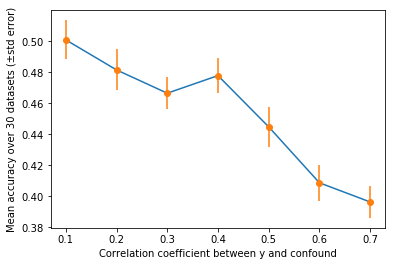

In [45]:
# First, computer error bars
errors = np.std(accuracies_2_1, axis=0)
errors = errors / np.sqrt(accuracies_2_1.shape[0])

# Figure, axis
f, ax = plt.subplots(1,1)
ax = plt.plot(accuracies_2_1.columns, accuracies_2_1.mean(axis=0))  # Add means
plt.errorbar(x=accuracies_2_1.columns, y=accuracies_2_1.mean(axis=0), yerr=errors, fmt='o')  # add error bars
plt.ylabel('Mean accuracy over 30 datasets (±std error)')
plt.xlabel('Correlation coefficient between y and confound')

#### 2.2 What happens if we regress out the confound within every fold?

In [66]:
n_obs = 100  # Number of observations
n_ind = 25   # Number of independent variables (X)
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# Here, we define several values for the point-biserial correlation between the confound and y.
# This value cannot be set too high; it is impossible to have very high correlations between a normally distributed and
# a binary variable.
corr_y_conf = [.7, .6, .5, .4, .3, .2, .1]

# For every 'corr_y_conf', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 30

# Pre-allocate numpy array (3 dimensions) for output accuracies
accuracies_2_2 = pd.DataFrame(columns=corr_y_conf, index=range(n_datasets))

# Loop over all corr_y_confs
for i, corr_y_confound in enumerate(corr_y_conf):
    print('\nCorrelation y/conf: %.3f ±.01' % corr_y_confound, end='')

    # Loop over datasets; 10 x per allowed_correlation
    for dataset_num in range(n_datasets):

        # Generate y first
        y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))

        attempt_y_conf = 1
        noise_sd = 1
        while True:
            confound = y + np.random.normal(0, noise_sd, len(y))  # Add some noise
            attempt_y_conf += 1

            # We allow correlations with ±0.01 absolute difference from the current corr_y_confound.
            if (corr_y_confound - .01) < np.corrcoef(x=confound, y=y)[0,1] < (corr_y_confound + .01):
                if silent:
                    print('.', end='')
                else:
                    print('Dataset found (%.3f, %d/%d)... ' % (np.corrcoef(x=confound, y=y)[0,1], dataset_num+1, n_datasets), end='')
                break

            if attempt_y_conf > 1000000:
                noise_sd = noise_sd-.005
                if silent:
                    print('-', end='')
                else:
                    print('Tried 1000000 generations, decreasing amount of noise...')

        # Generate random X of size (n_obs, n_ind)
        X = np.ndarray((n_obs, n_ind))
        noise_sd = 1
        for iii in range(n_ind):
            # Generate random vector.
            random_vec = np.random.normal(0, noise_sd, n_obs)
            X[:,iii] = random_vec
                
        # 10-fold stratified CV
        cv = StratifiedKFold(n_splits=n_splits)

        # Pipeline
        pipe = Pipeline([('scale', StandardScaler()), 
                         ('svc', SVC(kernel='linear'))])

        scores = []
        for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
            X_train = X[train_idx,:]
            X_test = X[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]

            # Pipeline
            pipe = Pipeline([('confreg', ConfoundRegressor(confound=confound, fit_idx=train_idx)),
                             ('scale', StandardScaler()), 
                             ('svc', SVC(kernel='linear'))])
            pipe.fit(X_train, y_train)
            fold_score = pipe.score(X_test, y_test)
            scores.append(fold_score)

        scores = np.array(scores)
        accuracies_2_2.loc[dataset_num, corr_y_confound] = scores.mean(axis=0)

        if not silent:
            print('###########\nDone. Mean accuracy over folds: %.3f\n##########\n' %scores.mean(axis=0))


Correlation y/conf: 0.700 ±.01..............................
Correlation y/conf: 0.600 ±.01..............................
Correlation y/conf: 0.500 ±.01..............................
Correlation y/conf: 0.400 ±.01..............................
Correlation y/conf: 0.300 ±.01..............................
Correlation y/conf: 0.200 ±.01..............................
Correlation y/conf: 0.100 ±.01..............................

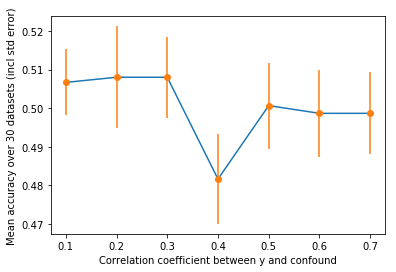

In [70]:
# First, compute error bars
errors = np.std(accuracies_2_2, axis=0)
errors = errors / np.sqrt(accuracies_2_2.shape[0])

# Figure, axis
f, ax = plt.subplots(1,1)
ax = plt.plot(accuracies_2_2.columns, accuracies_2_2.mean(axis=0))  # Add means
plt.errorbar(x=accuracies_2_2.columns, y=accuracies_2_2.mean(axis=0), yerr=errors, fmt='o')  # add error bars
plt.ylabel('Mean accuracy over %d datasets (incl std error)' % n_datasets)
plt.xlabel('Correlation coefficient between y and confound')

This is the situation we like: after regressing out the confound, there is a 50% accuracy. That is, there is no relation between X and y.

#### 2.3 And what happens if we regress out the confound within every fold, but separately on the train and test set?

In [68]:
n_obs = 100  # Number of observations
n_ind = 25   # Number of independent variables (X)
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# Here, we define several values for the point-biserial correlation between the confound and y.
# This value cannot be set too high; it is impossible to have very high correlations between a normally distributed and
# a binary variable.
corr_y_conf = [.7, .6, .5, .4, .3, .2, .1]

# For every 'corr_y_conf', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 30

# Pre-allocate numpy array (3 dimensions) for output accuracies
accuracies_2_3 = pd.DataFrame(columns=corr_y_conf, index=range(n_datasets))

# Loop over all corr_y_confs
for i, corr_y_confound in enumerate(corr_y_conf):
    print('\nCorrelation y/conf: %.3f ±.01' % corr_y_confound, end='')

    # Loop over datasets; 10 x per allowed_correlation
    for dataset_num in range(n_datasets):

        # Generate y first
        y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))

        attempt_y_conf = 1
        noise_sd = 1
        while True:
            confound = y + np.random.normal(0, noise_sd, len(y))  # Add some noise
            attempt_y_conf += 1

            # We allow correlations with ±0.01 absolute difference from the current corr_y_confound.
            if (corr_y_confound - .01) < np.corrcoef(x=confound, y=y)[0,1] < (corr_y_confound + .01):
                if silent:
                    print('.', end='')
                else:
                    print('Dataset found (%.3f, %d/%d)... ' % (np.corrcoef(x=confound, y=y)[0,1], dataset_num+1, n_datasets), end='')
                break

            if attempt_y_conf > 1000000:
                noise_sd = noise_sd-.005
                if silent:
                    print('-', end='')
                else:
                    print('Tried 1000000 generations, decreasing amount of noise...')

        # Generate random X of size (n_obs, n_ind)
        X = np.ndarray((n_obs, n_ind))
        noise_sd = 1
        for iii in range(n_ind):
            # Generate random vector.
            random_vec = np.random.normal(0, noise_sd, n_obs)
            X[:,iii] = random_vec
                
        # 10-fold stratified CV
        cv = StratifiedKFold(n_splits=n_splits)

        # Pipeline
        pipe = Pipeline([('scale', StandardScaler()), 
                         ('svc', SVC(kernel='linear'))])

        scores = []
        for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
            X_train = X[train_idx,:]
            X_test = X[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]

            # Pipeline
            pipe = Pipeline([('confreg', ConfoundRegressor(confound=confound, fit_idx=train_idx, cross_validate=False)),
                             ('scale', StandardScaler()), 
                             ('svc', SVC(kernel='linear'))])
            pipe.fit(X_train, y_train)
            fold_score = pipe.score(X_test, y_test)
            scores.append(fold_score)

        scores = np.array(scores)
        accuracies_2_3.loc[dataset_num, corr_y_confound] = scores.mean(axis=0)

        if not silent:
            print('###########\nDone. Mean accuracy over folds: %.3f\n##########\n' %scores.mean(axis=0))


Correlation y/conf: 0.700 ±.01.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately o

Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on te

Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on tes

.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on te

Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on tes

Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on tes

.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on te

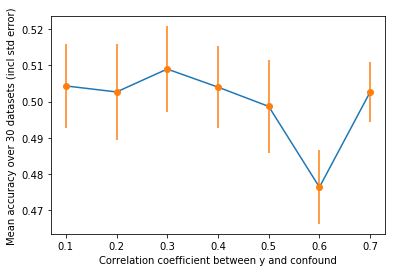

In [71]:
# First, compute error bars
errors = np.std(accuracies_2_3, axis=0)
errors = errors / np.sqrt(accuracies_2_3.shape[0])

# Figure, axis
f, ax = plt.subplots(1,1)
ax = plt.plot(accuracies_2_3.columns, accuracies_2_3.mean(axis=0))  # Add means
plt.errorbar(x=accuracies_2_3.columns, y=accuracies_2_3.mean(axis=0), yerr=errors, fmt='o')  # add error bars
plt.ylabel('Mean accuracy over %d datasets (incl std error)' % n_datasets)
plt.xlabel('Correlation coefficient between y and confound')

These results are the same as in Section 2.2. Regressing out the confound, separately for the train and test set, within every fold, does not lead to a below-chance accuracy.

# 3. What happens if we vary the number of independent variables

In [61]:
n_obs = 100  # Number of observations
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# Here, we fix the correlation between y and the confound to 0.65. 
# This is the correlation coefficient emperically found, between brain size and gender.
corr_y_confound = .6

# Now, we vary the number of independent variables (X)
n_independent_vars = [10, 25, 100, 250, 1000]

# For every 'n_independent_vars', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 10

# Pre-allocate numpy array (3 dimensions) for output accuracies
accuracies_3_1 = pd.DataFrame(columns=n_independent_vars, index=range(n_datasets))

# Loop over all corr_y_confs
for i, n_ind in enumerate(n_independent_vars):
    print('\nNumber of independent variables: %d' % n_ind, end='')

    # Loop over datasets; 10 x per allowed_correlation
    for dataset_num in range(n_datasets):

        # Generate y first
        y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))

        attempt_y_conf = 1
        noise_sd = 1
        while True:
            confound = y + np.random.normal(0, noise_sd, len(y))  # Add some noise
            attempt_y_conf += 1

            # We allow correlations with ±0.01 absolute difference from the current corr_y_confound.
            if (corr_y_confound - .01) < np.corrcoef(x=confound, y=y)[0,1] < (corr_y_confound + .01):
                if silent:
                    print('.', end='')
                else:
                    print('Dataset found (%.3f, %d/%d)... ' % (np.corrcoef(x=confound, y=y)[0,1], dataset_num+1, n_datasets), end='')
                break

            if attempt_y_conf > 1000000:
                noise_sd = noise_sd-.005
                if silent:
                    print('-', end='')
                else:
                    print('Tried 1000000 generations, decreasing amount of noise...')

        # Generate random X of size (n_obs, n_ind)
        X = np.ndarray((n_obs, n_ind))
        noise_sd = 1
        for iii in range(n_ind):
            # Generate random vector.
            random_vec = np.random.normal(0, noise_sd, n_obs)
            X[:,iii] = random_vec
        
        # Regress out the confound from X
        X = ConfoundRegressor(confound=confound, fit_idx=range(n_obs)).fit_transform(X=X)
        
        # 10-fold stratified CV
        cv = StratifiedKFold(n_splits=n_splits)

        # Pipeline
        pipe = Pipeline([('scale', StandardScaler()), 
                         ('svc', SVC(kernel='linear'))])

        scores = []
        for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
            X_train = X[train_idx,:]
            X_test = X[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]

            pipe.fit(X_train, y_train)
            fold_score = pipe.score(X_test, y_test)
            scores.append(fold_score)

        scores = np.array(scores)
        accuracies_3_1.loc[dataset_num, n_ind] = scores.mean(axis=0)

        if not silent:
            print('###########\nDone. Mean accuracy over folds: %.3f\n##########\n' %scores.mean(axis=0))


Number of independent variables: 10..........
Number of independent variables: 25..........
Number of independent variables: 100..........
Number of independent variables: 250..........
Number of independent variables: 1000..........

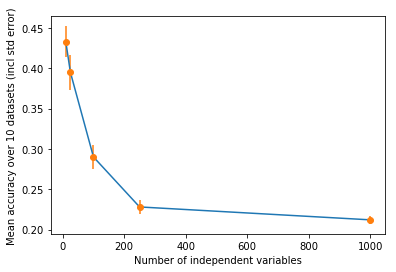

In [62]:
# First, compute error bars
errors = np.std(accuracies_3_1, axis=0)
errors = errors / np.sqrt(accuracies_3_1.shape[0])

# Figure, axis
f, ax = plt.subplots(1,1)
ax = plt.plot(accuracies_3_1.columns, accuracies_3_1.mean(axis=0))  # Add means
plt.errorbar(x=accuracies_3_1.columns, y=accuracies_3_1.mean(axis=0), yerr=errors, fmt='o')  # add error bars
plt.ylabel('Mean accuracy over %d datasets (incl std error)' % n_datasets)
plt.xlabel('Number of independent variables')

The higher the amount of independent variables, the larger the problem of below-chance accuracy.

#### 3.2 Now, regress within folds

In [72]:
n_obs = 100  # Number of observations
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# Here, we fix the correlation between y and the confound to 0.65. 
# This is the correlation coefficient emperically found, between brain size and gender.
corr_y_confound = .645

# Now, we vary the number of independent variables (X)
n_independent_vars = [10, 25, 100, 250, 1000]

# For every 'n_independent_vars', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 10

# Pre-allocate numpy array (3 dimensions) for output accuracies
accuracies_3_2 = pd.DataFrame(columns=n_independent_vars, index=range(n_datasets))

# Loop over all corr_y_confs
for i, n_ind in enumerate(n_independent_vars):
    print('\nNumber of independent variables: %d' % n_ind, end='')

    # Loop over datasets; 10 x per allowed_correlation
    for dataset_num in range(n_datasets):

        # Generate y first
        y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))

        attempt_y_conf = 1
        noise_sd = 1
        while True:
            confound = y + np.random.normal(0, noise_sd, len(y))  # Add some noise
            attempt_y_conf += 1

            # We allow correlations with ±0.01 absolute difference from the current corr_y_confound.
            if (corr_y_confound - .01) < np.corrcoef(x=confound, y=y)[0,1] < (corr_y_confound + .01):
                if silent:
                    print('.', end='')
                else:
                    print('Dataset found (%.3f, %d/%d)... ' % (np.corrcoef(x=confound, y=y)[0,1], dataset_num+1, n_datasets), end='')
                break

            if attempt_y_conf > 1000000:
                noise_sd = noise_sd-.005
                if silent:
                    print('-', end='')
                else:
                    print('Tried 1000000 generations, decreasing amount of noise...')

        # Generate random X of size (n_obs, n_ind)
        X = np.ndarray((n_obs, n_ind))
        noise_sd = 1
        for iii in range(n_ind):
            # Generate random vector.
            random_vec = np.random.normal(0, noise_sd, n_obs)
            X[:,iii] = random_vec
        
        # 10-fold stratified CV
        cv = StratifiedKFold(n_splits=n_splits)

        scores = []
        for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
            X_train = X[train_idx,:]
            X_test = X[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]

            pipe = Pipeline([('confreg', ConfoundRegressor(confound=confound, fit_idx=train_idx, cross_validate=True)),
                             ('scale', StandardScaler()), 
                             ('svc', SVC(kernel='linear'))])
            pipe.fit(X_train, y_train)
            fold_score = pipe.score(X_test, y_test)
            scores.append(fold_score)

        scores = np.array(scores)
        accuracies_3_2.loc[dataset_num, n_ind] = scores.mean(axis=0)

        if not silent:
            print('###########\nDone. Mean accuracy over folds: %.3f\n##########\n' %scores.mean(axis=0))


Number of independent variables: 10..........
Number of independent variables: 25..........
Number of independent variables: 100..........
Number of independent variables: 250..........
Number of independent variables: 1000..........

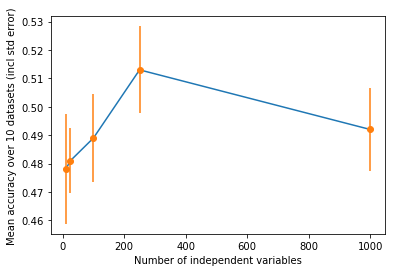

In [73]:
# First, compute error bars
errors = np.std(accuracies_3_2, axis=0)
errors = errors / np.sqrt(accuracies_3_2.shape[0])

# Figure, axis
f, ax = plt.subplots(1,1)
ax = plt.plot(accuracies_3_2.columns, accuracies_3_2.mean(axis=0))  # Add means
plt.errorbar(x=accuracies_3_2.columns, y=accuracies_3_2.mean(axis=0), yerr=errors, fmt='o')  # add error bars
plt.ylabel('Mean accuracy over %d datasets (incl std error)' % n_datasets)
plt.xlabel('Number of independent variables')

Again, the effect is how we would want it: regressing out the confound within every fold leads to a ± 50% accuracy

#### 3.2 For the sake of completeness, also regress out within every fold for the train and test set separately

In [74]:
n_obs = 100  # Number of observations
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# Here, we fix the correlation between y and the confound to 0.65. 
# This is the correlation coefficient emperically found, between brain size and gender.
corr_y_confound = .645

# Now, we vary the number of independent variables (X)
n_independent_vars = [10, 25, 100, 250, 1000]

# For every 'n_independent_vars', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 10

# Pre-allocate numpy array (3 dimensions) for output accuracies
accuracies_3_3 = pd.DataFrame(columns=n_independent_vars, index=range(n_datasets))

# Loop over all corr_y_confs
for i, n_ind in enumerate(n_independent_vars):
    print('\nNumber of independent variables: %d' % n_ind, end='')

    # Loop over datasets; 10 x per allowed_correlation
    for dataset_num in range(n_datasets):

        # Generate y first
        y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))

        attempt_y_conf = 1
        noise_sd = 1
        while True:
            confound = y + np.random.normal(0, noise_sd, len(y))  # Add some noise
            attempt_y_conf += 1

            # We allow correlations with ±0.01 absolute difference from the current corr_y_confound.
            if (corr_y_confound - .01) < np.corrcoef(x=confound, y=y)[0,1] < (corr_y_confound + .01):
                if silent:
                    print('.', end='')
                else:
                    print('Dataset found (%.3f, %d/%d)... ' % (np.corrcoef(x=confound, y=y)[0,1], dataset_num+1, n_datasets), end='')
                break

            if attempt_y_conf > 1000000:
                noise_sd = noise_sd-.005
                if silent:
                    print('-', end='')
                else:
                    print('Tried 1000000 generations, decreasing amount of noise...')

        # Generate random X of size (n_obs, n_ind)
        X = np.ndarray((n_obs, n_ind))
        noise_sd = 1
        for iii in range(n_ind):
            # Generate random vector.
            random_vec = np.random.normal(0, noise_sd, n_obs)
            X[:,iii] = random_vec
        
        # 10-fold stratified CV
        cv = StratifiedKFold(n_splits=n_splits)

        scores = []
        for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
            X_train = X[train_idx,:]
            X_test = X[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]

            pipe = Pipeline([('confreg', ConfoundRegressor(confound=confound, fit_idx=train_idx, cross_validate=False)),
                             ('scale', StandardScaler()), 
                             ('svc', SVC(kernel='linear'))])
            pipe.fit(X_train, y_train)
            fold_score = pipe.score(X_test, y_test)
            scores.append(fold_score)

        scores = np.array(scores)
        accuracies_3_3.loc[dataset_num, n_ind] = scores.mean(axis=0)

        if not silent:
            print('###########\nDone. Mean accuracy over folds: %.3f\n##########\n' %scores.mean(axis=0))


Number of independent variables: 10.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separat

Number of independent variables: 250.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
.Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separat

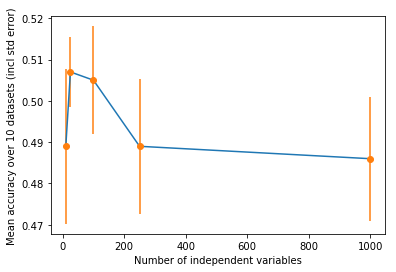

In [75]:
# First, compute error bars
errors = np.std(accuracies_3_3, axis=0)
errors = errors / np.sqrt(accuracies_3_3.shape[0])

# Figure, axis
f, ax = plt.subplots(1,1)
ax = plt.plot(accuracies_3_3.columns, accuracies_3_3.mean(axis=0))  # Add means
plt.errorbar(x=accuracies_3_3.columns, y=accuracies_3_3.mean(axis=0), yerr=errors, fmt='o')  # add error bars
plt.ylabel('Mean accuracy over %d datasets (incl std error)' % n_datasets)
plt.xlabel('Number of independent variables')

# The End

# Old stuff below

In [28]:
n_obs = 100  # Number of observations
n_ind = 25   # Number of independent variables (X)
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# In the code that follows, we generated multiple variables X, and ensure that the correlation 
# between X and the confound is below a certain value. To mimick the effect of regressing out 
# a confound before doing any other analyses/processing, you can set the maximally allowed 
# correlation to 0.00001. Here, we create an array to visualize the effect of multiple possible scenarios.
max_corr_x_conf = [.0001, .0003, .001, .003, .01, 0.03, .1, 0.15, 0.2, 0.25, .3, 1]

# Similarly, we define several values for the point-biserial correlation between the confound and y.
# This value cannot be set too high; it is impossible to have very high correlations between a normally distributed and
# a binary variable.
corr_y_conf = [.6, .5, .4, .3, .2, .1]

# For every combination of 'max_corr_x_conf' and 'corr_y_conf', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 10

# Pre-allocate numpy array (3 dimensions) for output accuracies
accuracies_2_1 = np.ndarray(shape=(n_datasets, len(corr_y_conf), len(max_corr_x_conf)))

# Loop over all max_corr_x_conf values
for i, max_corr_x_confound in enumerate(max_corr_x_conf):
    print('\nAllowed correlation x/y: %.4f' % max_corr_x_confound)
    
    # Loop over all corr_y_confs
    for ii, corr_y_confound in enumerate(corr_y_conf):
        print('\nCorrelation y/conf: %.4f' % corr_y_confound, end='')
        
        # Loop over datasets; 10 x per allowed_correlation
        for dataset_num in range(n_datasets):

            # Generate y first
            y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))
            
            attempt_y_conf = 1
            noise_sd = 1
            while True:
                confound = y + np.random.normal(0, noise_sd, len(y))  # Add some noise
                attempt_y_conf += 1
                
                # We allow correlations with ±0.01 absolute difference from the current corr_y_confound.
                if (corr_y_confound - .01) < np.corrcoef(x=confound, y=y)[0,1] < (corr_y_confound + .01):
                    if silent:
                        print('.', end='')
                    else:
                        print('Dataset found (%.3f, %d/%d)... ' % (np.corrcoef(x=confound, y=y)[0,1], dataset_num+1, n_datasets), end='')
                    break
                
                if attempt_y_conf > 1000000:
                    noise_sd = noise_sd-.005
                    if silent:
                        print('-', end='')
                    else:
                        print('Tried 1000000 generations, decreasing amount of noise...')

            # Generate random X of size (n_obs, n_ind)
            X = np.ndarray((n_obs, n_ind))
            noise_sd = 1
            for iii in range(n_ind):

                # Generate random vector, enforcing a (Pearson's) correlation between y and X lower than `allowed_correlation`
                attempt_y_X = 0
                while True:
                    attempt_y_X += 1
                    random_vec = np.random.normal(0, noise_sd, n_obs)

                    if np.abs(np.corrcoef(x=random_vec, y=confound)[0,1]) < max_corr_x_confound:
                        X[:,iii] = random_vec
                        break

                    if attempt_y_X > 100000:
                        noise_sd = noise_sd-.005
                        if silent:
                            print('+', end='')
                        else:
                            print('Tried 100000 generations, decreasing amount of noise...')

            # 10-fold stratified CV
            cv = StratifiedKFold(n_splits=n_splits)
            
            # Pipeline
            pipe = Pipeline([('scale', StandardScaler()), 
                             ('svc', SVC(kernel='linear'))])

            scores = []
            for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
                X_train = X[train_idx,:]
                X_test = X[test_idx,:]
                y_train = y[train_idx]
                y_test = y[test_idx]

                pipe.fit(X_train, y_train)
                fold_score = pipe.score(X_test, y_test)
                scores.append(fold_score)

            scores = np.array(scores)
            accuracies_2_1[dataset_num, ii, i] = scores.mean(axis=0)

            if not silent:
                print('###########\nDone. Mean accuracy over folds: %.3f\n##########\n' %scores.mean(axis=0))

Allowed correlation x/y: 0.0001
Correlation y/conf: 0.6000
..........Correlation y/conf: 0.5000
..........Correlation y/conf: 0.4000
..........Correlation y/conf: 0.3000
..........Correlation y/conf: 0.2000
..........Correlation y/conf: 0.1000
..........Allowed correlation x/y: 0.0003
Correlation y/conf: 0.6000
..........Correlation y/conf: 0.5000
..........Correlation y/conf: 0.4000
..........Correlation y/conf: 0.3000
..........Correlation y/conf: 0.2000
..........Correlation y/conf: 0.1000
..........Allowed correlation x/y: 0.0010
Correlation y/conf: 0.6000
..........Correlation y/conf: 0.5000
..........Correlation y/conf: 0.4000
..........Correlation y/conf: 0.3000
..........Correlation y/conf: 0.2000
..........Correlation y/conf: 0.1000
..........Allowed correlation x/y: 0.0030
Correlation y/conf: 0.6000
..........Correlation y/conf: 0.5000
..........Correlation y/conf: 0.4000
..........Correlation y/conf: 0.3000
..........Correlation y/conf: 0.2000
..........Correlation y/conf: 0

Visualizing the results is a bit harder here. We recreate the same graph we've shown before, but now for every value of corr_y_conf separately

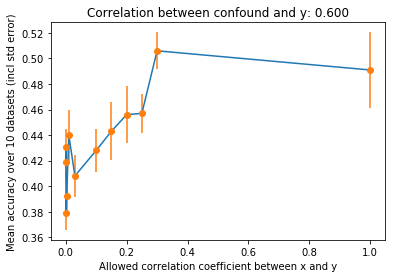

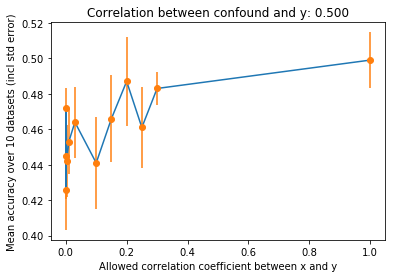

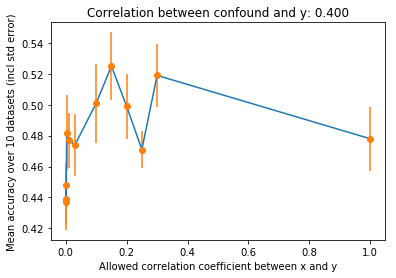

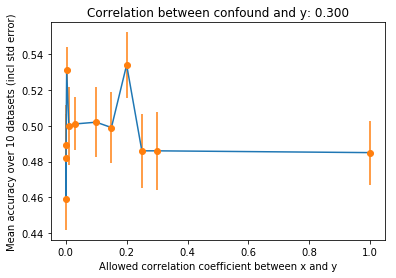

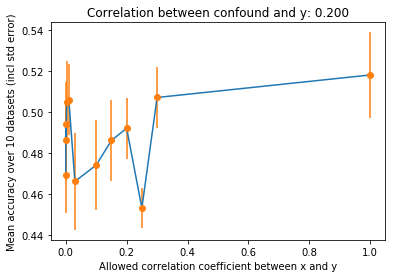

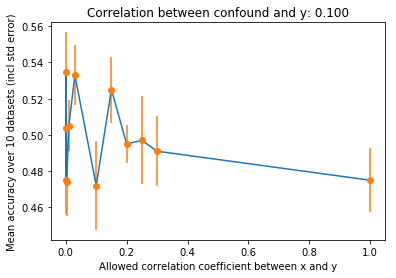

In [32]:
for i, corr_y_confound in enumerate(corr_y_conf):
    
    # Select accuracies for this corr_y_confound, and put in DataFrame
    accuracies_2_1_i = pd.DataFrame(accuracies_2_1[:,i,:], columns=max_corr_x_conf, index=range(n_datasets))
    
    # Calculate error bars
    errors = np.std(accuracies_2_1_i, axis=0)
    errors = errors / np.sqrt(accuracies_2_1_i.shape[0])
    f, ax = plt.subplots(1,1)
    ax = plt.plot(accuracies_2_1_i.columns, accuracies_2_1_i.mean(axis=0))
    plt.errorbar(x=accuracies_2_1_i.columns, y=accuracies_2_1_i.mean(axis=0), yerr=errors, fmt='o')
    plt.title('Correlation between confound and y: %.3f' % corr_y_confound)
    plt.ylabel('Mean accuracy over 10 datasets (incl std error)')
    plt.xlabel('Allowed correlation coefficient between x and y')

Remember, if we regress out the confound in advance we would be at the left-most point in each graph (x=0).
As might be expected, the higher the correlation between the confound and y, the greater the sub-chance accuracy effect.

#### 2.2 Within-fold regression

In [42]:
n_obs = 100  # Number of observations
n_ind = 25   # Number of independent variables (X)
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# In the code that follows, we generated multiple variables X, and ensure that the correlation 
# between X and the confound is below a certain value. To mimick the effect of regressing out 
# a confound before doing any other analyses/processing, you can set the maximally allowed 
# correlation to 0.00001. Here, we create an array to visualize the effect of multiple possible scenarios.
max_corr_x_conf = [.0001, .0003, .001, .003, .01, 0.03, .1, 0.15, 0.2, 0.25, .3, 1]

# Similarly, we define several values for the point-biserial correlation between the confound and y.
# This value cannot be set too high; it is impossible to have very high correlations between a normally distributed and
# a binary variable.
corr_y_conf = [.6, .5, .4, .3, .2, .1]

# For every combination of 'max_corr_x_conf' and 'corr_y_conf', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 10

# Pre-allocate numpy array (3 dimensions) for output accuracies
accuracies_2_2 = np.ndarray(shape=(n_datasets, len(corr_y_conf), len(max_corr_x_conf)))

# Loop over all max_corr_x_conf values
for i, max_corr_x_confound in enumerate(max_corr_x_conf):
    print('\nAllowed correlation x/y: %.4f' % max_corr_x_confound)
    
    # Loop over all corr_y_confs
    for ii, corr_y_confound in enumerate(corr_y_conf):
        print('\nCorrelation y/conf: %.4f' % corr_y_confound, end='')
        
        # Loop over datasets; 10 x per allowed_correlation
        for dataset_num in range(n_datasets):

            # Generate y first
            y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))
            
            attempt_y_conf = 1
            noise_sd = 1
            while True:
                confound = y + np.random.normal(0, noise_sd, len(y))  # Add some noise
                attempt_y_conf += 1
                
                # We allow correlations with ±0.01 absolute difference from the current corr_y_confound.
                if (corr_y_confound - .01) < np.corrcoef(x=confound, y=y)[0,1] < (corr_y_confound + .01):
                    if silent:
                        print('.', end='')
                    else:
                        print('Dataset found (%.3f, %d/%d)... ' % (np.corrcoef(x=confound, y=y)[0,1], dataset_num+1, n_datasets), end='')
                    break
                
                if attempt_y_conf > 1000000:
                    noise_sd = noise_sd-.005
                    if silent:
                        print('-', end='')
                    else:
                        print('Tried 1000000 generations, decreasing amount of noise...')

            # Generate random X of size (n_obs, n_ind)
            X = np.ndarray((n_obs, n_ind))
            noise_sd = 1
            for iii in range(n_ind):

                # Generate random vector, enforcing a (Pearson's) correlation between y and X lower than `allowed_correlation`
                attempt_y_X = 0
                while True:
                    attempt_y_X += 1
                    random_vec = np.random.normal(0, noise_sd, n_obs)

                    if np.abs(np.corrcoef(x=random_vec, y=confound)[0,1]) < max_corr_x_confound:
                        X[:,iii] = random_vec
                        break

                    if attempt_y_X > 100000:
                        noise_sd = noise_sd-.005
                        if silent:
                            print('+', end='')
                        else:
                            print('Tried 100000 generations, decreasing amount of noise...')

            # 10-fold stratified CV
            cv = StratifiedKFold(n_splits=n_splits)
            
            scores = []
            for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
                X_train = X[train_idx,:]
                X_test = X[test_idx,:]
                y_train = y[train_idx]
                y_test = y[test_idx]

                # Pipeline
                pipe = Pipeline([('confreg', ConfoundRegressor(confound=confound, fit_idx=train_idx, cross_validate=True)),
                                 ('scale', StandardScaler()), 
                                 ('svc', SVC(kernel='linear'))])

                pipe.fit(X_train, y_train)
                fold_score = pipe.score(X_test, y_test)
                scores.append(fold_score)

            scores = np.array(scores)
            accuracies_2_2[dataset_num, ii, i] = scores.mean(axis=0)

            if not silent:
                print('###########\nDone. Mean accuracy over folds: %.3f\n##########\n' %scores.mean(axis=0))

Allowed correlation x/y: 0.0001
Correlation y/conf: 0.6000
0.609, 1/30... 0.596, 2/30... 0.596, 3/30... 0.609, 4/30... 0.608, 5/30... 0.600, 6/30... 0.602, 7/30... 0.591, 8/30... 0.594, 9/30... 0.601, 10/30... 0.605, 11/30... 0.606, 12/30... 0.601, 13/30... 0.593, 14/30... 0.597, 15/30... 0.596, 16/30... 0.608, 17/30... 0.596, 18/30... 0.609, 19/30... 0.595, 20/30... 0.607, 21/30... 0.606, 22/30... 0.594, 23/30... 0.590, 24/30... 0.592, 25/30... 0.603, 26/30... 0.597, 27/30... 0.593, 28/30... 0.602, 29/30... 0.595, 30/30... Correlation y/conf: 0.5000
0.495, 1/30... 0.498, 2/30... 0.490, 3/30... 0.502, 4/30... 0.509, 5/30... 0.496, 6/30... 0.504, 7/30... 0.507, 8/30... 0.490, 9/30... 0.497, 10/30... 0.510, 11/30... 0.491, 12/30... 0.510, 13/30... 0.503, 14/30... 0.507, 15/30... 0.491, 16/30... 0.500, 17/30... 0.508, 18/30... 0.498, 19/30... 0.491, 20/30... 0.501, 21/30... 0.505, 22/30... 0.490, 23/30... 0.498, 24/30... 0.492, 25/30... 0.499, 26/30... 0.503, 27/30... 0.499, 28/30... 0.50

In [29]:
for i, corr_y_confound in enumerate(corr_y_conf):
    
    # Select accuracies for this corr_y_confound, and put in DataFrame
    accuracies_2_2_i = pd.DataFrame(accuracies_2_2_i[:,i,:], columns=correlation_y_x, index=range(n_datasets))
    
    # Calculate error bars
    errors = np.std(accuracies_2_2_i, axis=0)
    errors = errors / np.sqrt(accuracies_2_2_i.shape[0])
    f, ax = plt.subplots(1,1)
    ax = plt.plot(accuracies_2_2_i.columns, accuracies_2_2_i.mean(axis=0))
    plt.errorbar(x=accuracies_2_2_i.columns, y=accuracies_2_2_i.mean(axis=0), yerr=errors, fmt='o')
    plt.title('Correlation between confound and y: %.3f' % allowed_accuracy)
    plt.ylabel('Mean accuracy over 10 datasets (incl std error)')
    plt.xlabel('Allowed correlation coefficient between x and y')

NameError: name 'accuracies_2_2_i' is not defined

#### 2.3 Regression out confound within the folds, but separately for train and test set

In [35]:
n_obs = 100  # Number of observations
n_ind = 25   # Number of independent variables (X)
n_splits = 10  # Number of splits for KFold CV
silent = True  # suppresses some output

# In the code that follows, we generated multiple variables X, and ensure that the correlation 
# between X and the confound is below a certain value. To mimick the effect of regressing out 
# a confound before doing any other analyses/processing, you can set the maximally allowed 
# correlation to 0.00001. Here, we create an array to visualize the effect of multiple possible scenarios.
max_corr_x_conf = [.0001, .0003, .001, .003, .01, 0.03, .1, 0.15, 0.2, 0.25, .3, 1]

# Similarly, we define several values for the point-biserial correlation between the confound and y.
# This value cannot be set too high; it is impossible to have very high correlations between a normally distributed and
# a binary variable.
corr_y_conf = [.6, .5, .4, .3, .2, .1]

# For every combination of 'max_corr_x_conf' and 'corr_y_conf', we generate multiple datasets to estimate how well
# the decoding accuracy generalizes to other datasets. More datasets = better estimate, but takes longer to compute
n_datasets = 10

# Pre-allocate numpy array (3 dimensions) for output accuracies
accuracies_2_3 = np.ndarray(shape=(n_datasets, len(corr_y_conf), len(max_corr_x_conf)))

# Loop over all max_corr_x_conf values
for i, max_corr_x_confound in enumerate(max_corr_x_conf):
    print('\nAllowed correlation x/y: %.4f' % max_corr_x_confound)
    
    # Loop over all corr_y_confs
    for ii, corr_y_confound in enumerate(corr_y_conf):
        print('\nCorrelation y/conf: %.4f' % corr_y_confound, end='')
        
        # Loop over datasets; 10 x per allowed_correlation
        for dataset_num in range(n_datasets):

            # Generate y first
            y = np.array([0] * int(n_obs/2) + [1] * int(n_obs/2))
            
            attempt_y_conf = 1
            noise_sd = 1
            while True:
                confound = y + np.random.normal(0, noise_sd, len(y))  # Add some noise
                attempt_y_conf += 1
                
                # We allow correlations with ±0.01 absolute difference from the current corr_y_confound.
                if (corr_y_confound - .01) < np.corrcoef(x=confound, y=y)[0,1] < (corr_y_confound + .01):
                    if silent:
                        print('.', end='')
                    else:
                        print('Dataset found (%.3f, %d/%d)... ' % (np.corrcoef(x=confound, y=y)[0,1], dataset_num+1, n_datasets), end='')
                    break
                
                if attempt_y_conf > 1000000:
                    noise_sd = noise_sd-.005
                    if silent:
                        print('-', end='')
                    else:
                        print('Tried 1000000 generations, decreasing amount of noise...')

            # Generate random X of size (n_obs, n_ind)
            X = np.ndarray((n_obs, n_ind))
            noise_sd = 1
            for iii in range(n_ind):

                # Generate random vector, enforcing a (Pearson's) correlation between y and X lower than `allowed_correlation`
                attempt_y_X = 0
                while True:
                    attempt_y_X += 1
                    random_vec = np.random.normal(0, noise_sd, n_obs)

                    if np.abs(np.corrcoef(x=random_vec, y=confound)[0,1]) < max_corr_x_confound:
                        X[:,iii] = random_vec
                        break

                    if attempt_y_X > 100000:
                        noise_sd = noise_sd-.005
                        if silent:
                            print('+', end='')
                        else:
                            print('Tried 100000 generations, decreasing amount of noise...')

            # 10-fold stratified CV
            cv = StratifiedKFold(n_splits=n_splits)
            
            scores = []
            for fold, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y.reshape(-1,))):
                X_train = X[train_idx,:]
                X_test = X[test_idx,:]
                y_train = y[train_idx]
                y_test = y[test_idx]

                # Pipeline
                pipe = Pipeline([('confreg', ConfoundRegressor(confound=confound, fit_idx=train_idx, cross_validate=False)),
                                 ('scale', StandardScaler()), 
                                 ('svc', SVC(kernel='linear'))])

                fold_score = pipe.score(X_test, y_test)
                scores.append(fold_score)

            scores = np.array(scores)
            accuracies_2_3[dataset_num, ii, i] = scores.mean(axis=0)

            if not silent:
                print('###########\nDone. Mean accuracy over folds: %.3f\n##########\n' %scores.mean(axis=0))

Allowed correlation x/y: 0.0001
Correlation y/conf: 0.6000
0.608, 1/30... [ 0.3  0.6  0.4  0.4  0.5  0.6  0.4  0.7  0.5  0.5]
0.597, 2/30... [ 0.7  0.5  0.5  0.5  0.5  0.5  0.5  0.6  0.5  0.5]
0.596, 3/30... [ 0.5  0.5  0.4  0.5  0.5  0.4  0.7  0.5  0.6  0.3]
0.594, 4/30... [ 0.6  0.6  0.4  0.2  0.5  0.5  0.5  0.5  0.3  0.6]
0.594, 5/30... [ 0.5  0.7  0.6  0.4  0.6  0.5  0.5  0.6  0.4  0.5]
0.604, 6/30... [ 0.4  0.5  0.6  0.6  0.3  0.6  0.7  0.4  0.5  0.5]
0.607, 7/30... [ 0.4  0.5  0.7  0.2  0.4  0.6  0.4  0.4  0.4  0.4]
0.599, 8/30... [ 0.2  0.6  0.3  0.4  0.6  0.5  0.5  0.4  0.3  0.6]
0.600, 9/30... [ 0.4  0.3  0.5  0.6  0.6  0.5  0.4  0.6  0.6  0.6]
0.592, 10/30... [ 0.5  0.4  0.6  0.7  0.5  0.4  0.3  0.4  0.5  0.3]
0.601, 11/30... [ 0.4  0.1  0.3  0.3  0.3  0.3  0.5  0.4  0.2  0.7]
0.601, 12/30... [ 0.6  0.3  0.4  0.6  0.3  0.6  0.5  0.6  0.4  0.4]
0.601, 13/30... [ 0.6  0.4  0.6  0.6  0.5  0.2  0.6  0.6  0.4  0.5]
0.597, 14/30... [ 0.5  0.4  0.7  0.5  0.6  0.3  0.4  0.5  0.6  0.5

KeyboardInterrupt: 

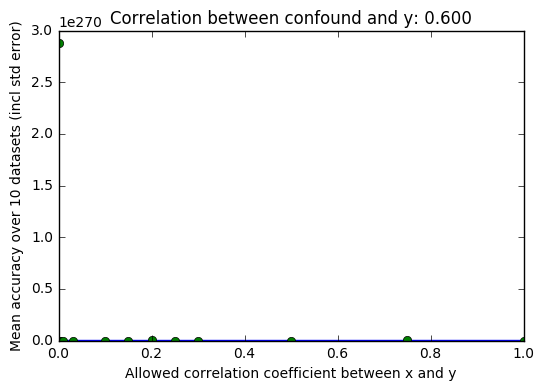

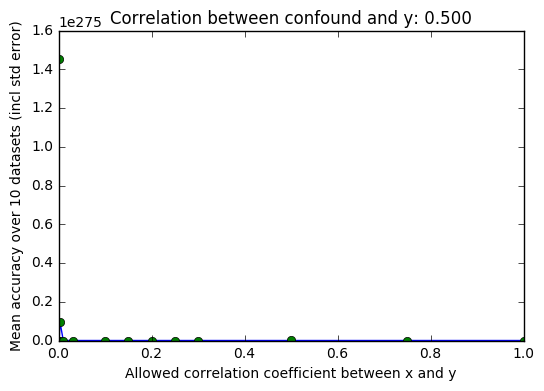

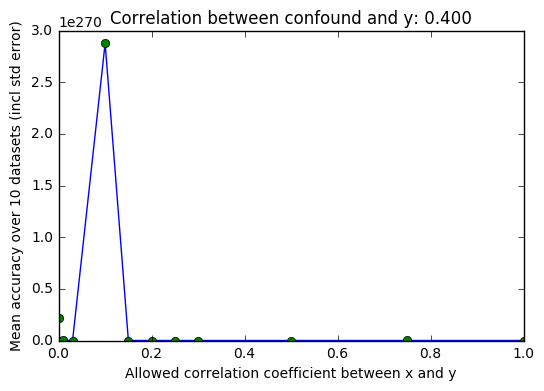

In [18]:
for i, corr_y_confound in enumerate(corr_y_conf):
    
    # Select accuracies for this corr_y_confound, and put in DataFrame
    accuracies_2_3_i = pd.DataFrame(accuracies_2_3_i[:,i,:], columns=correlation_y_x, index=range(n_datasets))
    
    # Calculate error bars
    errors = np.std(accuracies_2_3_i, axis=0)
    errors = errors / np.sqrt(accuracies_2_3_i.shape[0])
    f, ax = plt.subplots(1,1)
    ax = plt.plot(accuracies_2_3_i.columns, accuracies_2_3_i.mean(axis=0))
    plt.errorbar(x=accuracies_2_3_i.columns, y=accuracies_2_3_i.mean(axis=0), yerr=errors, fmt='o')
    plt.title('Correlation between confound and y: %.3f' % allowed_accuracy)
    plt.ylabel('Mean accuracy over 10 datasets (incl std error)')
    plt.xlabel('Allowed correlation coefficient between x and y')